In [1]:
import os
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import random


np.random.seed(42)

In [2]:
# UTILS

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    print('Number of samples', n_samples)
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

# 1. Import data from the 27 subjects

In [3]:
# define paths
input_folder = "data"
output_folder = "data_part2_E1"
os.makedirs(output_folder, exist_ok=True)

# iterate through all .zip files in the data folder
for i, zip_file_name in enumerate(os.listdir(input_folder)):
    if zip_file_name.endswith(".zip"):
        zip_path = os.path.join(input_folder, zip_file_name)
        print(zip_path)
        # select the file that we are interested in
        target_file_name = f"S{i+1}_A1_E1.mat"
            
        # open the .zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            # check if the target file is in the .zip
            if target_file_name in zip_file.namelist():
                # extract the target file and put it in the data_part2_E1 folder
                zip_file.extract(target_file_name, output_folder)
                print(f"Extracted: {target_file_name} from {zip_file_name}")
            else:
                print(f"File {target_file_name} not found in {zip_file_name}")


data/s1.zip
Extracted: S1_A1_E1.mat from s1.zip
data/s2.zip
Extracted: S2_A1_E1.mat from s2.zip
data/s3.zip
Extracted: S3_A1_E1.mat from s3.zip
data/s4.zip
Extracted: S4_A1_E1.mat from s4.zip
data/s5.zip
Extracted: S5_A1_E1.mat from s5.zip
data/s6.zip
Extracted: S6_A1_E1.mat from s6.zip
data/s7.zip
Extracted: S7_A1_E1.mat from s7.zip
data/s8.zip
Extracted: S8_A1_E1.mat from s8.zip
data/s9.zip
Extracted: S9_A1_E1.mat from s9.zip
data/s10.zip
Extracted: S10_A1_E1.mat from s10.zip
data/s11.zip
Extracted: S11_A1_E1.mat from s11.zip
data/s12.zip
Extracted: S12_A1_E1.mat from s12.zip
data/s13.zip
Extracted: S13_A1_E1.mat from s13.zip
data/s14.zip
Extracted: S14_A1_E1.mat from s14.zip
data/s15.zip
Extracted: S15_A1_E1.mat from s15.zip
data/s16.zip
Extracted: S16_A1_E1.mat from s16.zip
data/s17.zip
Extracted: S17_A1_E1.mat from s17.zip
data/s18.zip
Extracted: S18_A1_E1.mat from s18.zip
data/s19.zip
Extracted: S19_A1_E1.mat from s19.zip
data/s20.zip
Extracted: S20_A1_E1.mat from s20.zip
data/s2

# QUESTION 1. Preprocess the features

In [4]:
E1_data_path = 'data_part2_E1'

In [5]:
# extract features for 27 subjects and store features and labels in dictionaries

all_datasets = {}
all_labels = {}

# we will iterate over the 27 subjects and store the processed features in the all_datasets dict
# and the labels in the all_labels dict
for i in range (27):
    print(f'SUBJECT {i+1}')
    mat_path = os.path.join(E1_data_path, f'S{i+1}_A1_E1.mat')
    mat = loadmat(mat_path)

    emg = mat["emg"]
    print("EMG data dimension: {}".format(emg.shape))
    print("EMG data type: {}".format(type(emg)))
    stimulus = mat['restimulus']
    repetition = mat['rerepetition']


    n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
    print('Number of stimuli', n_stimuli)
    n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
    print('Number of repetitions', n_repetitions)

    mov_mean_length = 25
    mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length
    
    #initializing the data structure
    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

    # Define the features 
    
    # Mean absolute value (MAV)
    mav = lambda x: np.mean(np.abs(x), axis=0)
    # Standard Deviation (STD)
    std = lambda x: np.std(x, axis=0)
    # Maximum absolute Value (MaxAV)
    maxav = lambda x: np.max(np.abs(x), axis=0)
    # Root mean square (RMS)
    rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
    # Waveform length (WL)
    wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
    # Slope sign changes (SSC)
    ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
    
    
    # create the dataset for subject i+1
    # dimensions of the dataset : (12 stimuli * 10 repetitions, 6 features * 10 channels)
    dataset, labels = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc]
    )
    
    all_datasets[f"dataset_{i + 1}"] = dataset
    all_labels[f"labels_{i + 1}"] = labels
    
    print(f"dataset dimension: {dataset.shape}")
    print(f"labels dimension: {labels.shape}")



SUBJECT 1
EMG data dimension: (101014, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 2
EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 3
EMG data dimension: (100720, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 4
EMG data dimension: (100835, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
labels dimension: (120,)
SUBJECT 5
EMG data dimension: (100894, 10)
EMG data type: <class 'numpy.ndarray'>
Number of stimuli 12
Number of repetitions 10
Number of samples 120
dataset dimension: (120, 60)
label

# QUESTION 2. Visualize the features
For this part, we decided to visualize the variance of each of the 6 features across the 27 subjects on 6 separate heatmaps.
Thus the variance will be shown, depeding on both the channel and the type of stimulus.
To reduce dimensionnality, we averaged each feature for each subject for a specific stimulus in one channel, over the 10 repetitions.

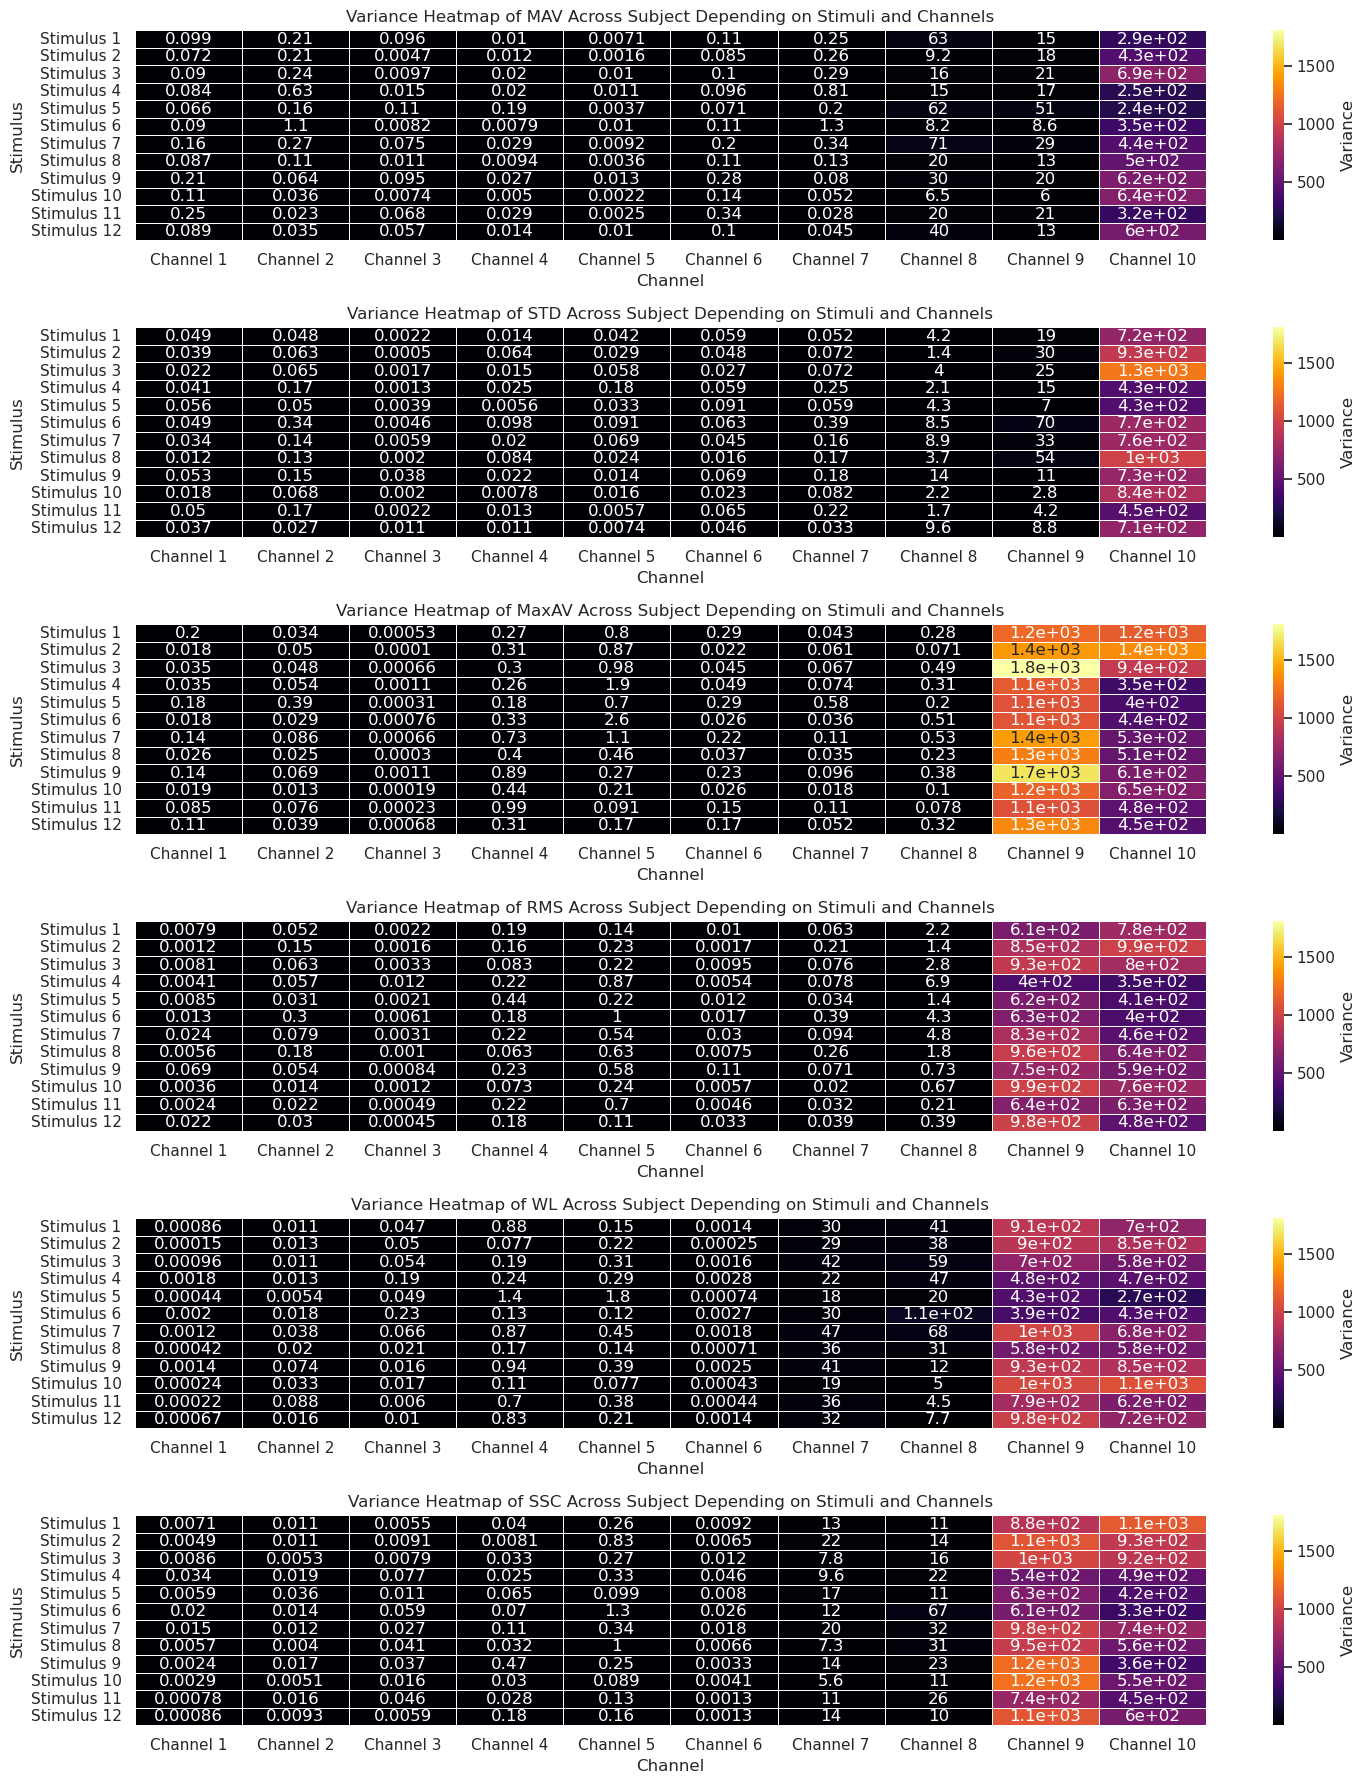

The feature with the highest overall variability is: MaxAV

Feature: MAV
  - Channel with the highest variability: Channel 10 (Stimulus 3)
  - Highest variability value: 686.0376

Feature: STD
  - Channel with the highest variability: Channel 10 (Stimulus 3)
  - Highest variability value: 1264.4570

Feature: MaxAV
  - Channel with the highest variability: Channel 9 (Stimulus 3)
  - Highest variability value: 1803.9958

Feature: RMS
  - Channel with the highest variability: Channel 10 (Stimulus 2)
  - Highest variability value: 988.0878

Feature: WL
  - Channel with the highest variability: Channel 10 (Stimulus 10)
  - Highest variability value: 1080.9676

Feature: SSC
  - Channel with the highest variability: Channel 9 (Stimulus 10)
  - Highest variability value: 1236.8190


In [6]:
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

n_channels = 10
n_stimuli = 12

# store the values corresponding to the 6 features in the 27 patients (the shapes will be (27, 12, 10)
# because we will take the average over the 10 repetitions of each stimulus)
all_feature_values = {feature: np.zeros((27, n_stimuli, n_channels)) for feature in feature_names}

# iterate over the 27 subjects
for subject in range(27):
    # get the dataset for the corresponding subject
    dataset = all_datasets[f"dataset_{subject + 1}"]
    
    # Fiterate over the channels (10) and the features (6)
    for channel_idx in range(n_channels):
        for feature_idx, feature_name in enumerate(feature_names):
            # take the values for a given feature for all stimuli (reshape to nb stimuli x nb repetitions)
            feature_values = dataset[:, channel_idx * len(feature_names) + feature_idx].reshape(n_stimuli, -1)
            
            # for this channel and this feature in this subject, take the average over the 10 repetitions
            mean_feature_values = np.mean(feature_values, axis=1)  # Averaging over repetitions
            # store the value in the 'general' dataset for all subjects
            all_feature_values[feature_name][subject, :, channel_idx] = mean_feature_values

# calculate the variance of all features across subjects to show in the heatmaps
feature_variance = {feature: np.var(all_feature_values[feature], axis=0) for feature in feature_names}


# to have the same range of colors for all features, we find the min and max variance to define the borders of the variance interval
min_value = min([np.min(feature_variance[feature]) for feature in feature_names])
max_value = max([np.max(feature_variance[feature]) for feature in feature_names])

# 6 heat maps showing the variance of the 6 features
plt.figure(figsize=(15, 18))  

for i, feature_name in enumerate(feature_names):
    plt.subplot(6, 1, i + 1)  # 6 rows and 1 column of subplots
    sns.heatmap(feature_variance[feature_name], annot=True, cmap="inferno", cbar=True,
                xticklabels=[f"Channel {i+1}" for i in range(n_channels)],
                yticklabels=[f"Stimulus {i+1}" for i in range(n_stimuli)],
                cbar_kws={'label': 'Variance'}, linewidths=0.5,
                vmin=min_value, vmax=max_value)
    plt.title(f"Variance Heatmap of {feature_name} Across Subject Depending on Stimuli and Channels")
    plt.xlabel("Channel")
    plt.ylabel("Stimulus")

plt.tight_layout()
plt.show()





# quantitative information
# 1feature with highest variability across all channels and stimuli
overall_variability = {feature: np.max(feature_variance[feature]) for feature in feature_names}
highest_variability_feature = max(overall_variability, key=overall_variability.get)
print(f"The feature with the highest overall variability is: {highest_variability_feature}")

# for each feature, find combination of stimulus and channel which gives max variability
for feature_name in feature_names:
    highest_variability_channel_idx = np.unravel_index(np.argmax(feature_variance[feature_name]), feature_variance[feature_name].shape)
    highest_variability_channel = highest_variability_channel_idx[1]
    highest_variability_stimulus = highest_variability_channel_idx[0]
    highest_variability_value = feature_variance[feature_name][highest_variability_channel_idx]
    
    print(f"\nFeature: {feature_name}")
    print(f"  - Channel with the highest variability: Channel {highest_variability_channel + 1} (Stimulus {highest_variability_stimulus + 1})")
    print(f"  - Highest variability value: {highest_variability_value:.4f}")


# QUESTION 3. Train on 26 subjects and test on 1

In [25]:
# randomly select one subject for testing
test_subject_idx = random.randint(0, 26)
test_subject_idx = 25
# create the training set with all subject except the test subject
train_datasets = []
train_labels = []
for train_subject_idx in range(27):
    if train_subject_idx != test_subject_idx:
        train_datasets.append(all_datasets[f"dataset_{train_subject_idx + 1}"])
        train_labels.append(all_labels[f"labels_{train_subject_idx + 1}"])

# concatenate data from all training subjects
X_train = np.concatenate(train_datasets, axis=0)
y_train = np.concatenate(train_labels, axis=0)

# define the test data from the test subject
X_test = all_datasets[f"dataset_{test_subject_idx + 1}"]
y_test = all_labels[f"labels_{test_subject_idx + 1}"]

# initialize the Gradient Boosting model
gb_clf = GradientBoostingClassifier()

# train model on training data
gb_clf.fit(X_train, y_train)

# make predictions with trained model on test data
y_pred = gb_clf.predict(X_test)

# evaluate accuracy by comparing predicted and true value for the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Performance on randomly chosen test Subject {test_subject_idx + 1}: {accuracy:.4f}")


Performance on randomly chosen test Subject 26: 0.5000


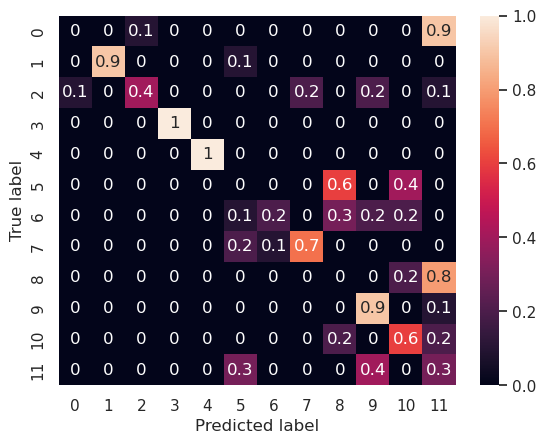

In [27]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

# QUESTION 4. Cross validation (26 train, 1 test)

Training and testing for fold 1 (Test Subject: 1)
Accuracy for fold 1: 0.3250
Training and testing for fold 2 (Test Subject: 2)
Accuracy for fold 2: 0.1833
Training and testing for fold 3 (Test Subject: 3)
Accuracy for fold 3: 0.4250
Training and testing for fold 4 (Test Subject: 4)
Accuracy for fold 4: 0.2833
Training and testing for fold 5 (Test Subject: 5)
Accuracy for fold 5: 0.4250
Training and testing for fold 6 (Test Subject: 6)
Accuracy for fold 6: 0.3417
Training and testing for fold 7 (Test Subject: 7)
Accuracy for fold 7: 0.3417
Training and testing for fold 8 (Test Subject: 8)
Accuracy for fold 8: 0.3917
Training and testing for fold 9 (Test Subject: 9)
Accuracy for fold 9: 0.1917
Training and testing for fold 10 (Test Subject: 10)
Accuracy for fold 10: 0.3917
Training and testing for fold 11 (Test Subject: 11)
Accuracy for fold 11: 0.3000
Training and testing for fold 12 (Test Subject: 12)
Accuracy for fold 12: 0.3417
Training and testing for fold 13 (Test Subject: 13)
Acc

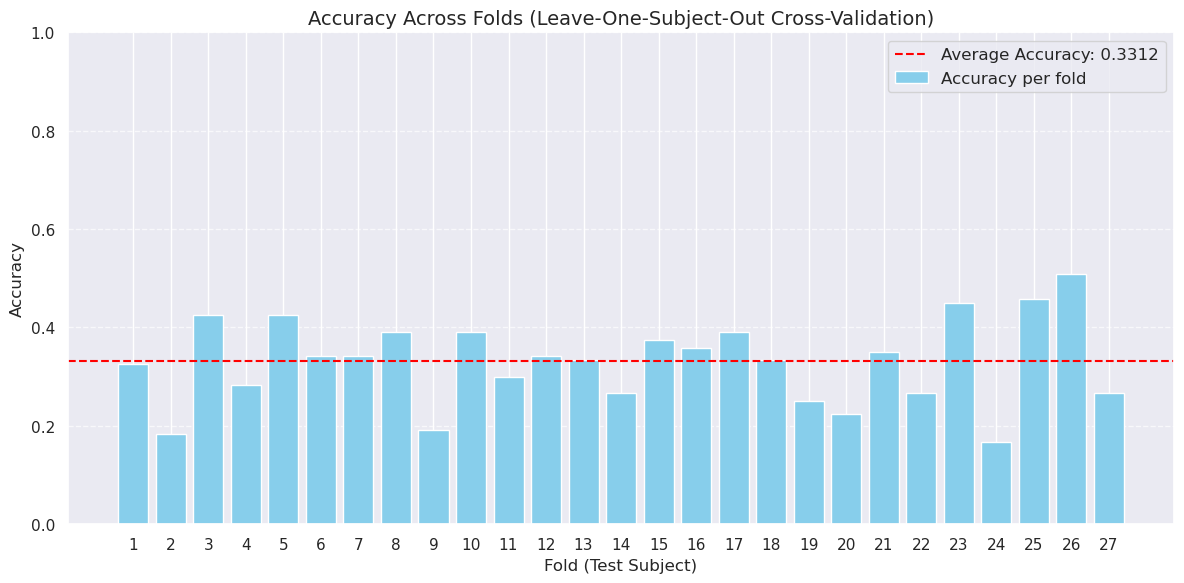

In [22]:
# initialize the classifier
gb_clf = GradientBoostingClassifier()

# liste to store accuracy results for each fold
performances = []

# iterate through all 27 subjects
for test_subject_idx in range(27):
    print(f"Training and testing for fold {test_subject_idx + 1} (Test Subject: {test_subject_idx + 1})")
    
    train_datasets = []
    train_labels = []
    
    for train_subject_idx in range(27):
        if train_subject_idx != test_subject_idx:
            train_datasets.append(all_datasets[f"dataset_{train_subject_idx + 1}"])
            train_labels.append(all_labels[f"labels_{train_subject_idx + 1}"])
    
    X_train = np.concatenate(train_datasets, axis=0)
    y_train = np.concatenate(train_labels, axis=0)
    
    X_test = all_datasets[f"dataset_{test_subject_idx + 1}"]
    y_test = all_labels[f"labels_{test_subject_idx + 1}"]

    # train the model
    gb_clf.fit(X_train, y_train)
    
    # make predictions on the test data
    y_pred = gb_clf.predict(X_test)
    
    # evaluate the accuracy of the model for this fold
    accuracy = accuracy_score(y_test, y_pred)
    performances.append(accuracy)
    print(f"Accuracy for fold {test_subject_idx + 1}: {accuracy:.4f}")
    
average_accuracy = np.mean(performances)
print(f"\nAverage classification accuracy across all folds: {average_accuracy:.4f}")


# show the accuracy values for each fold
folds = np.arange(1, 28)
plt.figure(figsize=(12, 6))
plt.bar(folds, performances, color='skyblue', label='Accuracy per fold')

# add the average accuracy as a dashed line
plt.axhline(y=average_accuracy, color='red', linestyle='--', label=f'Average Accuracy: {average_accuracy:.4f}')

plt.xlabel('Fold (Test Subject)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Across Folds (Leave-One-Subject-Out Cross-Validation)', fontsize=14)
plt.xticks(folds) 
plt.ylim(0, 1) 
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# QUESTION 5. Cross validation (growing size of training set)

Number of Training Subjects: 1, Accuracy: 0.0000
Number of Training Subjects: 2, Accuracy: 0.1917
Number of Training Subjects: 3, Accuracy: 0.1500
Number of Training Subjects: 4, Accuracy: 0.1333
Number of Training Subjects: 5, Accuracy: 0.1667
Number of Training Subjects: 6, Accuracy: 0.1500
Number of Training Subjects: 7, Accuracy: 0.1583
Number of Training Subjects: 8, Accuracy: 0.1417
Number of Training Subjects: 9, Accuracy: 0.1250
Number of Training Subjects: 10, Accuracy: 0.1583
Number of Training Subjects: 11, Accuracy: 0.1417
Number of Training Subjects: 12, Accuracy: 0.2167
Number of Training Subjects: 13, Accuracy: 0.1917
Number of Training Subjects: 14, Accuracy: 0.1667
Number of Training Subjects: 15, Accuracy: 0.2250
Number of Training Subjects: 16, Accuracy: 0.2417
Number of Training Subjects: 17, Accuracy: 0.2000
Number of Training Subjects: 18, Accuracy: 0.2167
Number of Training Subjects: 19, Accuracy: 0.2333
Number of Training Subjects: 20, Accuracy: 0.2500
Number of

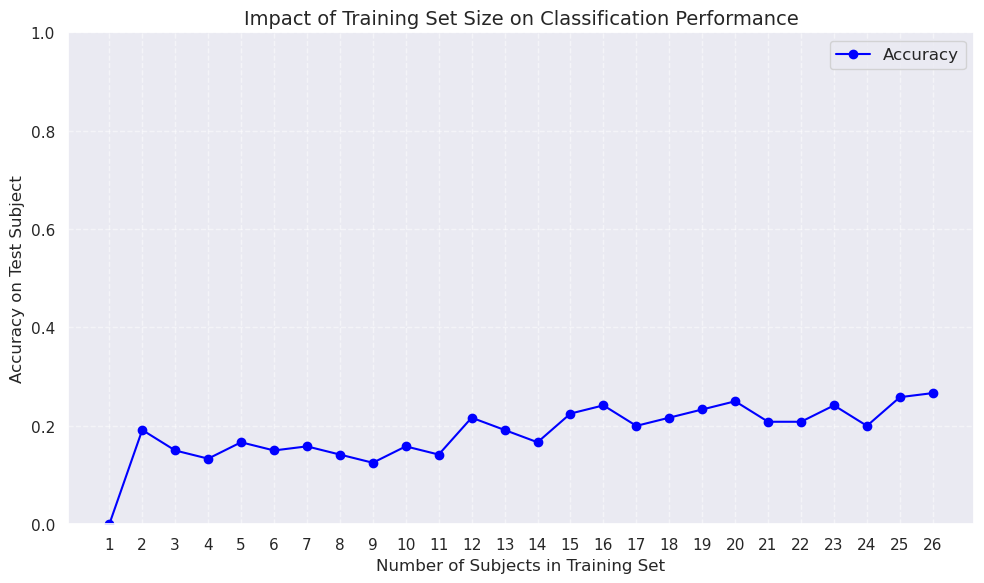

In [28]:
# we keep the same test subject, here we choose subject 27
test_subject_idx = 26  
X_test = all_datasets[f"dataset_{test_subject_idx + 1}"]
y_test = all_labels[f"labels_{test_subject_idx + 1}"]

# lists to store the arrays
num_train_subjects = []
performances = []

# iterate to increase the number of subjects in the trainset step by step
for train_subject_count in range(1, 27):  

    #to store the training data from the n subjects (depending on the 'fold')
    train_datasets = []
    train_labels = []
    
    for train_subject_idx in range(train_subject_count):
        train_datasets.append(all_datasets[f"dataset_{train_subject_idx + 1}"])
        train_labels.append(all_labels[f"labels_{train_subject_idx + 1}"])
    
    # concatenate the data from all subjects in the training set
    X_train = np.concatenate(train_datasets, axis=0)
    y_train = np.concatenate(train_labels, axis=0)
    
    
    # initialize the classifier
    gb_clf = GradientBoostingClassifier()
    
    # train the model
    gb_clf.fit(X_train, y_train)
    
    # evaluate accuracy on the test set
    y_pred = gb_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    num_train_subjects.append(train_subject_count)
    performances.append(accuracy)

    print(f"Number of Training Subjects: {train_subject_count}, Accuracy: {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_train_subjects, performances, marker='o', color='blue', label='Accuracy')
plt.title('Impact of Training Set Size on Classification Performance', fontsize=14)
plt.xlabel('Number of Subjects in Training Set', fontsize=12)
plt.ylabel('Accuracy on Test Subject', fontsize=12)
plt.xticks(range(1, 27))
plt.ylim(0, 1)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
